<h1> Building A Traffic Collision Prediction Model </h1>

This notebook will involve data wrangling, feature engineering and building a prediction model using supervised learning to predict the severity of an accident given attributes of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option('display.max_columns',50)
df = pd.read_csv(r'Data-Collisions.csv', parse_dates = ['INCDATE'])
df.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  \
0  Matched  Intersection  37475.0   
1  Matched         Block      NaN   
2  Matched         Block      NaN   
3  Matched         Block      NaN   
4  Matched  Intersection  34387.0   

                                      LOCATION EXCEPTRSNCODE EXCEPTRSNDESC  \
0                   5TH AVE NE AND NE 103RD ST                         NaN   
1   AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N           NaN           NaN   
2  4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST           NaN           NaN   
3     2ND AVE BETWEEN MARION ST AND MADISON ST                         NaN   
4              SWIFT AVE S AND SWIFT AV OFF RP           NaN           NaN   

   SEVERITYCODE.1                    SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  \
0               2                Injury Collision        Angles            2   
1               1  Property Damage Only Collision     Sideswipe            2   
2               1  Property Damage Only Collision    Parked Car            4   
3               1  Property Damage Only Collision         Other            3   
4               2                Injury Collision        Angles            2   

   PEDCOUNT  PEDCYLCOUNT  VEHCOUNT                   INCDATE  \
0         0            0         2 2013-03-27 00:00:00+00:00   
1         0            0         2 2006-12-20 00:00:00+00:00   
2         0            0         3 2004-11-18 00:00:00+00:00   
3         0            0         3 2013-03-29 00:00:00+00:00   
4         0            0         2 2004-01-28 00:00:00+00:00   

                  INCDTTM                             JUNCTIONTYPE  \
0    3/27/2013 2:54:00 PM   At Intersection (intersection related)   
1   12/20/2006 6:55:00 PM  Mid-Block (not related to intersection)   
2  11/18/2004 10:20:00 AM  Mid-Block (not related to intersection)   
3    3/29/2013 9:26:00 AM  Mid-Block (not related to intersection)   
4    1/28/2004 8:04:00 AM   At Intersection (intersection related)   

   SDOT_COLCODE                                       SDOT_COLDESC  \
0            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   
1            16  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...   
2            14       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END   
3            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   
4            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   

  INATTENTIONIND UNDERINFL   WEATHER ROADCOND                LIGHTCOND  \
0            NaN         N  Overcast      Wet                 Daylight   
1            NaN         0   Raining      Wet  Dark - Street Lights On   
2            NaN         0  Overcast      Dry                 Daylight   
3            NaN         N     Clear      Dry                 Daylight   
4            NaN         0   Raining      Wet                 Daylight   

  PEDROWNOTGRNT  SDOTCOLNUM SPEEDING ST_COLCODE  \
0           NaN         NaN      NaN         10   
1           NaN   6354039.0      NaN         11   
2           NaN   4323031.0      NaN         32   
3           NaN         NaN      NaN         23   
4           NaN   4028032.0      NaN         10   

                                          ST_COLDESC  SEGLANEKEY  \
0                                  Entering at angle           0   
1  From same direction - both going straight - bo...           0   
2                             One parked--one moving           0   
3                   From same direction - all others           0   
4                             

<h1> Cleaning the Data </h1>

In this dataset, the columns SEVERITYCODE and SEVERITYCODE.1 are identical to each other and convey the same information. Hence in the following step, it is dropped.

In [3]:
df.drop('SEVERITYCODE.1',axis = 1, inplace = True)

In [4]:
#drop the unique key for incident,secondary key for incident,report no. as they dont contribute to prediction of severity
df.drop(['INCKEY','COLDETKEY','REPORTNO'],axis = 1, inplace = True)

The UNDERIFL column contains 4 different values. Y,1,N,0 and NaN. It is necessary to make the column consistent to have only **1 for Under the Influence and 0 for Not Under the Influence** Filling up the missing values and making consistent binary indications in the Under Influence columns

In [5]:
df['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [6]:
df.loc[(df['UNDERINFL'] == 'Y'),'UNDERINFL'] = 1
df.loc[(df['UNDERINFL'] == 'N'),'UNDERINFL'] = 0
df.loc[(df['UNDERINFL'] == '1'),'UNDERINFL'] = 1
df.loc[(df['UNDERINFL'] == '0'),'UNDERINFL'] = 0
df['UNDERINFL'].unique()

array([0, nan, 1], dtype=object)

In [7]:
temp = df[['SEVERITYCODE','SEVERITYDESC']]
temp[~(temp.duplicated())]

SEVERITYCODE                    SEVERITYDESC
0             2                Injury Collision
1             1  Property Damage Only Collision

In [8]:
df['UNDERINFL'].isna().value_counts()

False    189789
True       4884
Name: UNDERINFL, dtype: int64

This dataset has only 2 severity levels

These 2 functions serve to find the percentage of Missing Values in each column and then produce a Dataframe of these results to help up get a better understanding of the missing data.

In [9]:
def missingvaluepercentages(features,datafr):
    numberofnanvalues = []
    nanvaluepercentage = []
    featureswithnan = []
    totalvalues = datafr.shape[0]
    for feature in features:
        try:
            nanvalues = datafr[feature].isna().value_counts()[1]
        except:
            nanvalues = 0
        numberofnanvalues.append(nanvalues)
        if nanvalues > 0:
            nanvaluepercent = ((nanvalues/totalvalues)*100).round(2)
        else:
            nanvaluepercent = 0.00
        nanvaluepercentage.append(nanvaluepercent)
        featureswithnan.append(feature)
            
    return numberofnanvalues,nanvaluepercentage,featureswithnan


def visualizemissingdata(numberofnanvalues,nanvaluepercentage,features):
    #order from highest to lowest for nanvalues and nanvalue%
    idx = np.array(numberofnanvalues).argsort()[::-1]
    nanvaluearray = np.array(numberofnanvalues)[idx]
    nanvaluepercentagearray = np.array(nanvaluepercentage)[idx]
    featuresarray = np.array(features)[idx]
    data = np.concatenate([nanvaluearray.reshape(1,-1),nanvaluepercentagearray.reshape(1,-1)],axis = 0)
    missingvaluedf = pd.DataFrame(data = data, columns = featuresarray, 
                                  index = ['Missing Value Number','Missing Value Percentage'])
    return missingvaluedf
    


In [10]:
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)

In [11]:
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)

In [12]:
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

<h3> Analysis </h3>

98% of the data in column **PEDROWNOTGRNT** is missing and we are not in a position to speculate if the Pedestrian was granted the right of way given the lack of information. Furthermore, both columns **EXCEPTRSDESC** and **EXCEPTRSNCODE** only have Not Enough Information as it's only available data, hence this isn't enough to make any conclusive action on the missing data of these columns. 

**INTKEY** is a key to each intersection. While intersections can have experience more collisions, which will be investigated later using box plots and barcharts, this column which already has so much of NaN values, can be removed.

**INATTENTIONIND** also has a large number of missing values. While we could replace the missing values with 'N', given the number of missing values, it would be an unnecessary amount of speculation. Hence we drop this column too. 

**SDOTCOLNUM** is only a reference number given to each collision, and has no impact on our prediction model. Hence we may remove this column too. 

In [13]:
df.drop(['PEDROWNOTGRNT','EXCEPTRSNDESC','EXCEPTRSNCODE','INTKEY','INATTENTIONIND','SDOTCOLNUM'],axis = 1,inplace = True)

In [14]:
#visualizing missing data after dropping the above columns
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

<h3> Analysis </h3>
Now the main culprit is from the **SPEEDING** column, however it is safe to assume that while Y represents cases where speeding was involved, the missing values represent cases where speeding was not involved

In [15]:
#replacing 'Y' with 1 and Missing Values with 0 in the SPEEDING Column
df.loc[(df['SPEEDING'] == 'Y'),'SPEEDING'] = 1
df.loc[(df['SPEEDING'].isna()),'SPEEDING'] = 0
df['SPEEDING'].value_counts()

0    185340
1      9333
Name: SPEEDING, dtype: int64

In [16]:
#visualizing missing data after adjusting the speeding column
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

In [17]:
#drop the LOCATION column
df.drop(['LOCATION'],axis = 1,inplace = True)

In [18]:
df['UNDERINFL'].value_counts(dropna = False)

0.0    180668
1.0      9121
NaN      4884
Name: UNDERINFL, dtype: int64

<h3> Analysis </h3>

We shall drop all the NaN values off these columns. Note that **Unknown** and **Other** instances are still present in these columns. 


In [19]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
#df['SDOT_COLCODE'].replace(to_replace = {0:np.nan},inplace = True)
#df['SDOT_COLDESC'].replace(to_replace = {'NOT ENOUGH INFORMATION / NOT APPLICABLE':np.nan},inplace = True)

In [20]:
#visualizing missing data after replacing the Unknown and Others values
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

Collision codes are worth investigating into to see if certain collisions have effect on the severity. Hence while we drop the description column of each collision, we keep the collision code column. 

In [21]:
st_colcode = df[['ST_COLCODE','ST_COLDESC']]
st_colcodefinal = st_colcode[~(st_colcode.duplicated())].style.hide_index()
sdot_colcode = df[['SDOT_COLCODE','SDOT_COLDESC']]
sdot_colcodefinal = sdot_colcode[~(sdot_colcode.duplicated())].style.hide_index()

In [22]:
df.drop(['ST_COLDESC','SDOT_COLDESC'],axis = 1, inplace = True)

In [23]:
df.head()

SEVERITYCODE           X          Y  OBJECTID   STATUS      ADDRTYPE  \
0             2 -122.323148  47.703140         1  Matched  Intersection   
1             1 -122.347294  47.647172         2  Matched         Block   
2             1 -122.334540  47.607871         3  Matched         Block   
3             1 -122.334803  47.604803         4  Matched         Block   
4             2 -122.306426  47.545739         5  Matched  Intersection   

                     SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0                Injury Collision        Angles            2         0   
1  Property Damage Only Collision     Sideswipe            2         0   
2  Property Damage Only Collision    Parked Car            4         0   
3  Property Damage Only Collision         Other            3         0   
4                Injury Collision        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                   INCDATE                 INCDTTM  \
0            0         2 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1            0         2 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2            0         3 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3            0         3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4            0         2 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY HITPARKEDCAR  
0             0            N  
1             0            N  
2             0            N  
3             0            N  
4             0            N

In [24]:
df.isnull().sum()

SEVERITYCODE     0
X                0
Y                0
OBJECTID         0
STATUS           0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
INCDATE          0
INCDTTM          0
JUNCTIONTYPE     0
SDOT_COLCODE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
SPEEDING         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
dtype: int64

<h3> Analysis </h3>

As some of the attributes still consist of the entry **Unknown**. In fact a large number of entries are Unknown, hence dropping these data would result in loss of a large number of valuable training samples. Hence these entries are replaced by the most occuring entry in these columns.

In [25]:
featureswithunknownentry = []
for column in df.columns.tolist():
    if len(df.loc[df[column] == 'Unknown']) > 0:
        featureswithunknownentry.append(column)


C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [26]:
featureswithunknownentry

['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']

In [27]:
for feature in featureswithunknownentry:
    topoccurence = df[feature].describe()[2]
    df.loc[df[feature] == 'Unknown',feature] = topoccurence

Now all **Unknown** entries have been replaced in all columns. 

In [28]:
#Drop OBJECTID and STATUS columns
df.drop(['OBJECTID','STATUS'],axis = 1, inplace = True)

In [29]:
#replacing the 'Y' and 'N' values of HITPARKEDCAR column with 1 and 0 respectively
df.loc[df['HITPARKEDCAR'] == 'Y','HITPARKEDCAR'] = 1
df.loc[df['HITPARKEDCAR'] == 'N','HITPARKEDCAR'] = 0
df.head()

SEVERITYCODE           X          Y      ADDRTYPE  \
0             2 -122.323148  47.703140  Intersection   
1             1 -122.347294  47.647172         Block   
2             1 -122.334540  47.607871         Block   
3             1 -122.334803  47.604803         Block   
4             2 -122.306426  47.545739  Intersection   

                     SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0                Injury Collision        Angles            2         0   
1  Property Damage Only Collision     Sideswipe            2         0   
2  Property Damage Only Collision    Parked Car            4         0   
3  Property Damage Only Collision         Other            3         0   
4                Injury Collision        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                   INCDATE                 INCDTTM  \
0            0         2 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1            0         2 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2            0         3 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3            0         3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4            0         2 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0

In [30]:
severitycode = df[['SEVERITYCODE']]
dffeatures = df[df.columns.tolist()[1:]]

In [31]:
dffeatures['INCTIME'] = pd.to_datetime(dffeatures['INCDTTM'])

In [32]:
dffeatures_ver2 = dffeatures.copy()
dffeatures_ver2.dtypes

X                            float64
Y                            float64
ADDRTYPE                      object
SEVERITYDESC                  object
COLLISIONTYPE                 object
PERSONCOUNT                    int64
PEDCOUNT                       int64
PEDCYLCOUNT                    int64
VEHCOUNT                       int64
INCDATE          datetime64[ns, UTC]
INCDTTM                       object
JUNCTIONTYPE                  object
SDOT_COLCODE                   int64
UNDERINFL                     object
WEATHER                       object
ROADCOND                      object
LIGHTCOND                     object
SPEEDING                       int64
ST_COLCODE                    object
SEGLANEKEY                     int64
CROSSWALKKEY                   int64
HITPARKEDCAR                   int64
INCTIME               datetime64[ns]
dtype: object

In [33]:
#to be deleted later
test = dffeatures_ver2['INCTIME'].dt.hour
test.isna().sum()

0

<h3> Analysis </h3> 

As we have successfully converted the **INCDTTM** columns to datetime format, now we can use it to create time periods to identify the periods at which accidents occur and if the time range of accident has any correlation with the severity code. We shall specify 6 time periods: *Late Night, Early Morning, Morning, Noon, Evening, Night* 

In some cases we do not have the time of incident. For these we specify it as *Other*


In [34]:
dffeatures_ver2['TIMEOFDAY'] = np.nan
dffeatures_ver2.loc[((dffeatures_ver2['INCTIME'].dt.hour >= 0) & (dffeatures_ver2['INCTIME'].dt.hour < 4)),'TIMEOFDAY'] = 'Late Night'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 4) & (dffeatures_ver2['INCTIME'].dt.hour < 8),'TIMEOFDAY'] = 'Early Morning'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 8) & (dffeatures_ver2['INCTIME'].dt.hour < 12),'TIMEOFDAY'] = 'Morning'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 12) & (dffeatures_ver2['INCTIME'].dt.hour < 16),'TIMEOFDAY'] = 'Noon'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 16) & (dffeatures_ver2['INCTIME'].dt.hour < 20),'TIMEOFDAY'] = 'Evening'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 20) & (dffeatures_ver2['INCTIME'].dt.hour < 24),'TIMEOFDAY'] = 'Night'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour == 0) & (dffeatures_ver2['INCTIME'].dt.minute == 0) &
               (dffeatures_ver2['INCTIME'].dt.second == 0),'TIMEOFDAY'] = 'Other'

In [35]:
dffeatures_ver2['YEAR'] = dffeatures_ver2['INCDATE'].dt.year
dffeatures_ver2['MONTH'] = dffeatures_ver2['INCDATE'].dt.month
dffeatures_ver2['DAY'] = dffeatures_ver2['INCDATE'].dt.dayofweek

Day of the week format in Python is as follows:
 - 0 : Monday
 - 1 : Tuesday
 - 2 : Wednesday
 - 3 : Thursday
 - 4 : Friday
 - 5 : Saturday
 - 6 : Sunday

In [36]:
dffeatures_ver2.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                    INCDATE                 INCDTTM  \
0 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR             INCTIME TIMEOFDAY  YEAR  MONTH  DAY  
0             0             0 2013-03-27 14:54:00      Noon  2013      3    2  
1             0             0 2006-12-20 18:55:00   Evening  2006     12    2  
2             0             0 2004-11-18 10:20:00   Morning  2004     11    3  
3             0             0 2013-03-29 09:26:00   Morning  2013      3    4  
4             0             0 2004-01-28 08:04:00   Morning  2004      1    2

<h3> Analysis </h3>

Given that we have gotten the Year, Month, Date and Time period of colission, the **INCTIME, INCDTTM and INCDATE** columns are dropped from dffeatures

In [37]:
dffinal_ver1 = dffeatures_ver2.drop(['INCTIME', 'INCDTTM', 'INCDATE'], axis = 1)
dfcombined_original = pd.concat([dffinal_ver1,severitycode], axis = 1)
dfcombined_original.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  YEAR  MONTH  DAY  SEVERITYCODE  
0             0             0      Noon  2013      3    2             2  
1             0             0   Evening  2006     12    2             1  
2             0             0   Morning  2004     11    3             1  
3             0             0   Morning  2013      3    4             1  
4             0             0   Morning  2004      1    2             2

In [38]:
#create a copy of the 
#dfcombined_analysis = 
dfcombined = dfcombined_original.copy()
dfcombined.isna().sum()

X                0
Y                0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
JUNCTIONTYPE     0
SDOT_COLCODE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
SPEEDING         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
TIMEOFDAY        0
YEAR             0
MONTH            0
DAY              0
SEVERITYCODE     0
dtype: int64

In [39]:
import folium as fl
from folium import plugins

seattlemap = fl.Map(location = [47.606209, -122.332069],zoom_start = 10)

colissions = plugins.MarkerCluster().add_to(seattlemap)
tuplecombined  = tuple(zip(dfcombined.X,dfcombined.Y,dfcombined.SEVERITYCODE,dfcombined.SEVERITYDESC))[:5000]
#lat,lng,sever,severdesc
for i in range(len(tuplecombined)):
    temp = str(tuplecombined[i][2]) + " " + str(tuplecombined[i][3])
    fl.Marker(location = [tuplecombined[i][1],tuplecombined[i][0]],
             icon = None,
             popup = temp).add_to(colissions)
    
seattlemap

<h1> Data Analysis and Visualization to find the most important attributes </h1>

<h3> First Year, Month, Week of the Day and Time of Day are investigated </h3>

In [40]:
def make_countdf(col_name, df , indexlist = None):
    var_investigated = df[col_name].unique().tolist()
    var_investigated.sort()
    vardf = pd.DataFrame(data = np.nan,columns = [1,2],index = var_investigated)
    for i in var_investigated:
        amt1 = len(df.loc[(df[col_name] == i) & (df['SEVERITYCODE'] == 1)])
        amt2 = len(df.loc[(df[col_name] == i) & (df['SEVERITYCODE'] == 2)])
        vardf.loc[i,1] = amt1
        vardf.loc[i,2] = amt2
    if indexlist is not None:
        vardf[col_name] = indexlist
        vardf.set_index(col_name, drop = True, inplace = True)
        #vardf.set_index(indexlist)
    return vardf

In [41]:
yearlydf = make_countdf(col_name = 'YEAR', df = dfcombined)
display(yearlydf.style.background_gradient(cmap = 'Reds',axis = 0))

In [42]:
yearlydf.index.values

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

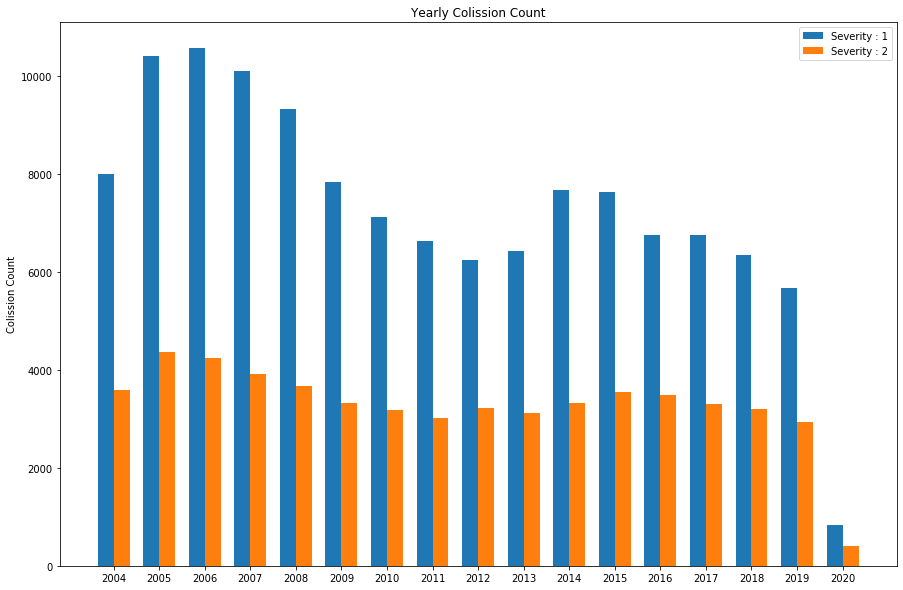

In [43]:
years = yearlydf.index.values
x = np.arange(len(years))
width = 0.35
ax = plt.figure(figsize = (15,10)).add_subplot(111)
cat1 = ax.bar(x - width/2, yearlydf[1], width, label = 'Severity : 1')
cat2 = ax.bar(x + width/2, yearlydf[2], width, label = 'Severity : 2')

ax.set_ylabel('Colission Count')
ax.set_title('Yearly Colission Count')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()


<h3> Insights from the above Plot </h3>

It is clear that there is no direct relationship on year with severity as the variation in number of colissions of both severity varies randomly with year. In essence there is no impact of a particular year on the severity. This makes general sense as the severity of a colission, logically, would not have any effect by which year it is. However we do see that 2020 has far fewer colissions. This is attributed to 2 factors:

- The United States is a hotspot of the ongoing **COVID-19** Pandemic which has forced many states into lockdown and many individuals are opting to work from home, shop online and reduce outside activities. Hence this has caused the number of colissions to drop.
- The year 2020 is still not over.

Plotting the colissions for a particular month

In [44]:
months = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec']
monthlydf = make_countdf(col_name = 'MONTH', df = dfcombined, indexlist = months)
display(monthlydf.style.background_gradient(cmap = 'Reds',axis = 0))

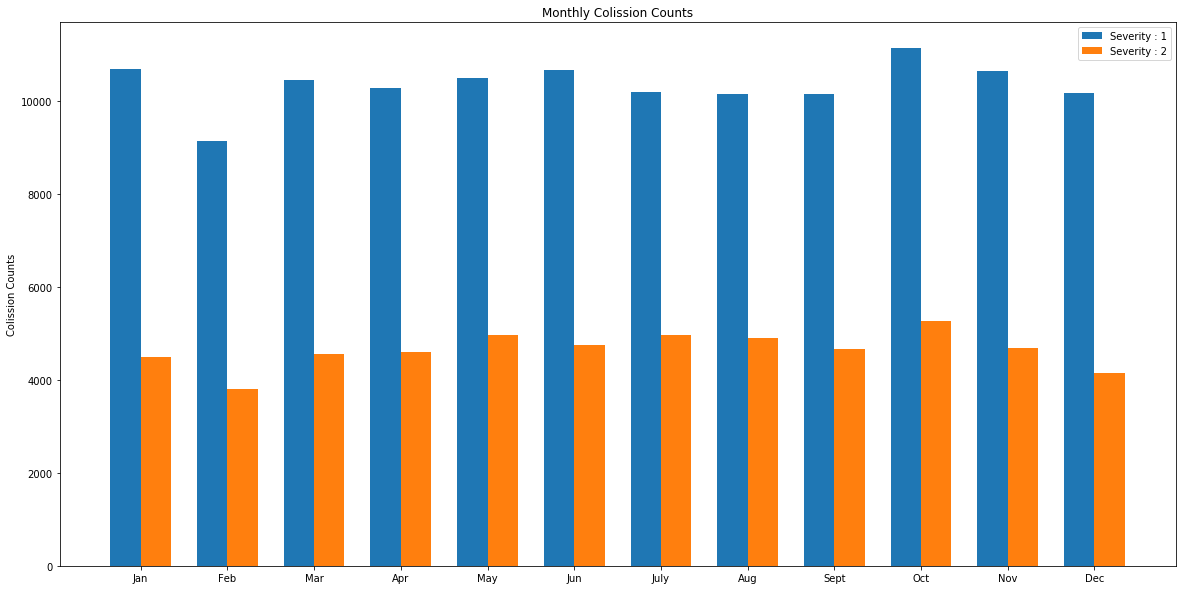

In [45]:
x_months = np.arange(len(months))
width = 0.35
ax1 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1 = ax1.bar(x_months - (width/2), monthlydf[1],width, label = 'Severity : 1')
sev2 = ax1.bar(x_months + (width/2), monthlydf[2],width, label = 'Severity : 2')


ax1.set_title('Monthly Colission Counts')
ax1.set_ylabel('Colission Counts')
ax1.set_xticks(x_months)
ax1.set_xticklabels(months)
ax1.legend()


<h3> Insights from the above Plot </h3>

It is clear from the above plots that there is no significant variation among the months when it comes to either Severity Code and Number of colissions.  

Plotting colissions for a particular day of week

In [46]:
day_of_week = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
dailydf = make_countdf(col_name = 'DAY', df = dfcombined, indexlist = day_of_week)
display(dailydf.style.background_gradient(cmap = 'Reds',axis = 0))

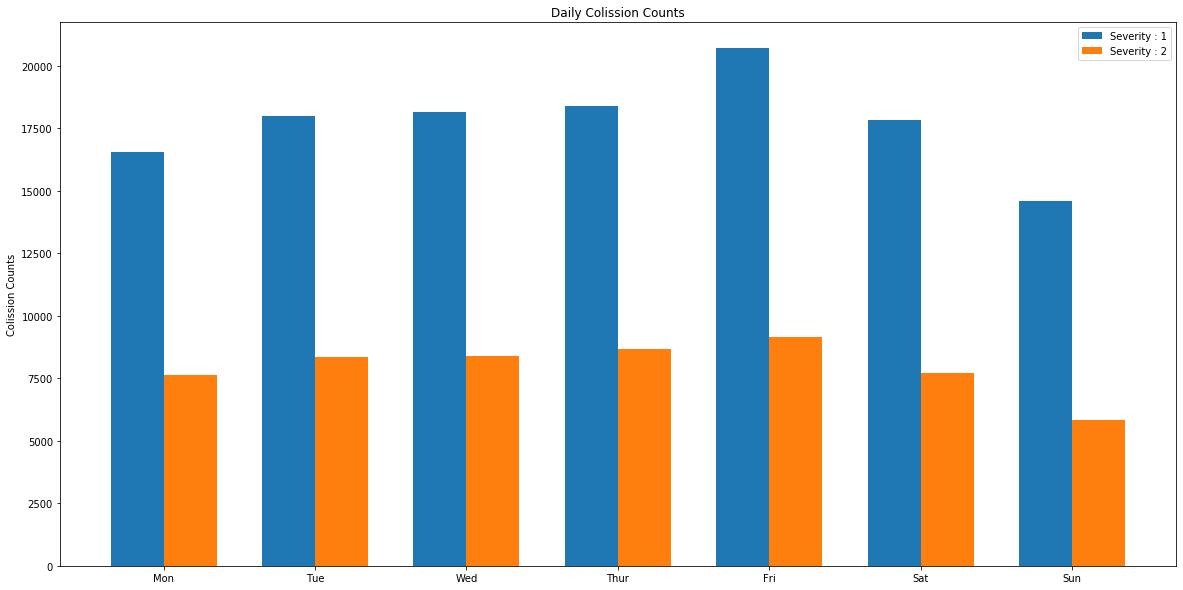

In [47]:
days = np.arange(len(day_of_week))
width = 0.35
ax2 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1_day = ax2.bar(days - (width/2), dailydf[1], width, label = 'Severity : 1')
sev2_day = ax2.bar(days + (width/2), dailydf[2], width, label = 'Severity : 2')

ax2.set_title('Daily Colission Counts')
ax2.set_ylabel('Colission Counts')
ax2.set_xticks(days)
ax2.set_xticklabels(day_of_week)
ax2.legend()

From the above Daily Colission plot and the preceding plots with respect to Yearly and Monthly colissions, there is no significant impact on these 3 attributes on the colission. Hence we can dismiss these three attributes from the predictive model. 


In [48]:
#drop YEAR, MONTH, DAY
dfcombined_ver2 = dfcombined_original.drop(['YEAR','MONTH','DAY'],axis = 1)
dfcombined_ver2.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  SEVERITYCODE  
0             0             0      Noon             2  
1             0             0   Evening             1  
2             0             0   Morning             1  
3             0             0   Morning             1  
4             0             0   Morning             2

<h2>Given how traffic varies depending on time of day, we hall investigate further into the **TIMEOFDAY** attribute</h2>

In [49]:
timeofdaydf = make_countdf(col_name = 'TIMEOFDAY', df = dfcombined_ver2)
display(timeofdaydf.style.background_gradient(cmap = 'Reds',axis = 0))

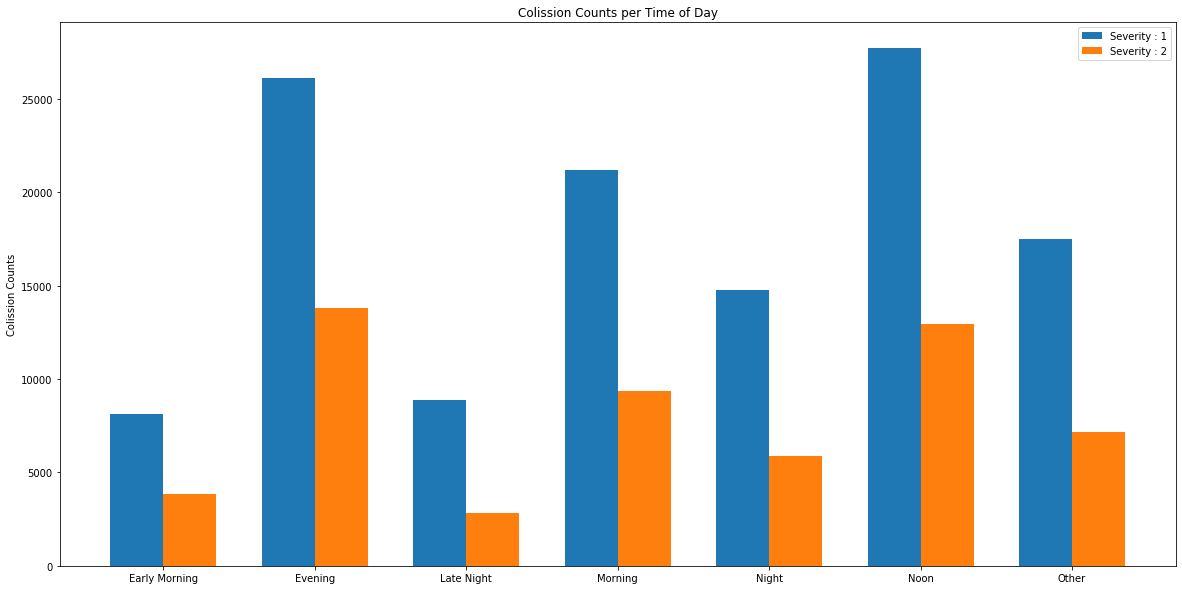

In [50]:
time_of_day = np.arange(len(dfcombined_ver2['TIMEOFDAY'].unique().tolist()))
width = 0.35
ax3 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1_time = ax3.bar(time_of_day - (width/2), timeofdaydf[1], width, label = 'Severity : 1')
sev2_time = ax3.bar(time_of_day + (width/2), timeofdaydf[2], width, label = 'Severity : 2')

ax3.set_title('Colission Counts per Time of Day')
ax3.set_ylabel('Colission Counts')
ax3.set_xticks(time_of_day)
ax3.set_xticklabels(timeofdaydf.index.values)
ax3.legend()

From the above visualization, it seems that Evening, Morning, Noon and Other categories tend to have more collisions.

To investigate the relationship between the categorical variables and the severity which is a binary value (1 and 2), we cannot use the ANOVA method as there is no normal distribution among the severity. Instead we shall use the Chi Squared Test. 

In [51]:
temptable = timeofdaydf.transpose()
contingencytable = temptable.to_numpy()

In [52]:
#we produce a contingency table to be given to the Scipy Chi2_contingency method
contingencytable

array([[ 8108., 26116.,  8894., 21168., 14761., 27717., 17494.],
       [ 3818., 13828.,  2816.,  9381.,  5856., 12940.,  7170.]])

In [53]:
from scipy.stats import chi2_contingency
chi2val,p,dof,expected = chi2_contingency(contingencytable)

In [54]:
p

2.401041385982495e-134

<h3>Investigate the ADDRTYPE and how it correlates with the Severity of Colission</h3>

In [55]:
addrtypedf = make_countdf(col_name = 'ADDRTYPE',df = dfcombined_ver2)
display(addrtypedf.style.background_gradient(cmap = 'Reds', axis = 0))

<h3>Investigate the SEVERITYDESC and how it correlates with the Severity of Colission</h3>


In [56]:
sevdescdf = make_countdf(col_name = 'SEVERITYDESC',df = dfcombined_ver2)
display(sevdescdf.style.background_gradient(cmap = 'Reds', axis = 0))

Creating a count dateframe of the ADDRTYPE as above shows that SEVERITYDESC should not be considered as an attribute as it is a direct description of the SEVERITY CODE OF COLISSION. Hence we shall drop it from the dataset

In [57]:
#drop YEAR, MONTH, DAY, ADDRTYPE
dfcombined_ver3 = dfcombined_original.drop(['YEAR','MONTH','DAY','SEVERITYDESC'],axis = 1)
dfcombined_ver3.head()

X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0 -122.323148  47.703140  Intersection        Angles            2         0   
1 -122.347294  47.647172         Block     Sideswipe            2         0   
2 -122.334540  47.607871         Block    Parked Car            4         0   
3 -122.334803  47.604803         Block         Other            3         0   
4 -122.306426  47.545739  Intersection        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                             JUNCTIONTYPE  \
0            0         2   At Intersection (intersection related)   
1            0         2  Mid-Block (not related to intersection)   
2            0         3  Mid-Block (not related to intersection)   
3            0         3  Mid-Block (not related to intersection)   
4            0         2   At Intersection (intersection related)   

   SDOT_COLCODE UNDERINFL   WEATHER ROADCOND                LIGHTCOND  \
0            11         0  Overcast      Wet                 Daylight   
1            16         0   Raining      Wet  Dark - Street Lights On   
2            14         0  Overcast      Dry                 Daylight   
3            11         0     Clear      Dry                 Daylight   
4            11         0   Raining      Wet                 Daylight   

   SPEEDING ST_COLCODE  SEGLANEKEY  CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  \
0         0         10           0             0             0      Noon   
1         0         11           0             0             0   Evening   
2         0         32           0             0             0   Morning   
3         0         23           0             0             0   Morning   
4         0         10           0             0             0   Morning   

   SEVERITYCODE  
0             2  
1             1  
2             1  
3             1  
4             2

<h2>Splitting the data into a Train Set and a Test Set</h2>

In order to maintain the ratio of Severity Code within both Train and Test sets o ensure both sets are representative of the data, Stratified Splitting is used.

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in splitter.split(dfcombined_ver3, dfcombined_ver3['SEVERITYCODE']):
    strat_train_set = dfcombined_ver3.loc[train_index]
    strat_test_set  = dfcombined_ver3.loc[test_index]

In [59]:
strat_train_set['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

In [60]:
strat_test_set['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

In [61]:
dfcombined_ver3['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

As observed from the above **value_counts** results, the strat_train_set and strat_test_set are representative of all the data in dfcombined_ver3 as the ratio of SEVERITYCODE is maintained

In [62]:
#make a copy of the train_set and DONT touch the test_set 
dftraining = strat_train_set.copy()
#its easier to deal with an categorical variable than dealing with an integer code. Hence the SDOT_COLCODE and 
#As sdot_colcodefinal and st_colcodefinal are Style Objects, we need to make them to Dataframes
sdot_colcodefinaldf = sdot_colcodefinal.data
st_colcodefinaldf = st_colcodefinal.data
for (code,desc) in zip(sdot_colcodefinaldf['SDOT_COLCODE'],sdot_colcodefinaldf['SDOT_COLDESC']):
    dftraining.loc[dftraining['SDOT_COLCODE'] == code, 'SDOT_COLCODE'] = desc
for (code,desc) in zip(st_colcodefinaldf['ST_COLCODE'],st_colcodefinaldf['ST_COLDESC']):
    dftraining.loc[dftraining['ST_COLCODE'] == code, 'ST_COLCODE'] = desc
dftraining.head()


X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  \
157437 -122.315789  47.664923         Block    Rear Ended            0   
134015 -122.344947  47.720482         Block       Head On            2   
168699 -122.339357  47.609781         Block    Rear Ended            2   
156901 -122.315518  47.613354  Intersection         Other            2   
40099  -122.263691  47.682926  Intersection     Sideswipe            4   

        PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
157437         0            0         3   
134015         0            0         2   
168699         0            0         2   
156901         0            0         1   
40099          0            0         2   

                                   JUNCTIONTYPE  \
157437  Mid-Block (not related to intersection)   
134015  Mid-Block (not related to intersection)   
168699     Mid-Block (but intersection related)   
156901   At Intersection (intersection related)   
40099    At Intersection (intersection related)   

                                             SDOT_COLCODE UNDERINFL   WEATHER  \
157437       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0  Overcast   
134015       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0     Clear   
168699       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0     Clear   
156901      MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT         0     Clear   
40099   MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0  Overcast   

       ROADCOND                LIGHTCOND  SPEEDING  \
157437      Dry  Dark - Street Lights On         0   
134015      Dry  Dark - Street Lights On         0   
168699      Dry                 Daylight         0   
156901      Dry  Dark - Street Lights On         0   
40099       Dry                 Daylight         0   

                                               ST_COLCODE  SEGLANEKEY  \
157437  From same direction - both going straight - on...           0   
134015               From opposite direction - all others           0   
168699  From same direction - both going straight - on...           0   
156901                                       Fixed object           0   
40099   Same direction -- both turning right -- both m...           0   

        CROSSWALKKEY  HITPARKEDCAR   TIMEOFDAY  SEVERITYCODE  
157437             0             0  Late Night             1  
134015             0             0       Night             1  
168699             0             0     Evening             1  
156901             0             0       Night             2  
40099              0             0       Other             1

In [63]:
dftrainingfeatures = dftraining.iloc[:,:-1]
severitylabel = dftraining.iloc[:,-1]

<h4> Create a new class prep_df to be used with a Pipeline for extracting the required attributes</h4>

In [78]:
from sklearn.base import BaseEstimator,TransformerMixin

class prep_df(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribute_names = attribs
    def fit(self,X):
        return self
    def transform(self,X):
        return X[self.attribute_names].values
    


<h4> This pipeline allows to extract the required categorical features and encode them using Ordinal Encoder</h4>

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
cat_attribs = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','SDOT_COLCODE','WEATHER','ROADCOND','LIGHTCOND',
              'ST_COLCODE','SPEEDING','TIMEOFDAY']
cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs)),
                        ('oe',OrdinalEncoder()),
                        ])

In [80]:
dffeatures_cat = cat_pipeline.fit_transform(dftrainingfeatures)
dffeatures_cat

array([[ 0.,  7.,  4., ..., 17.,  0.,  2.],
       [ 0.,  2.,  4., ...,  7.,  0.,  4.],
       [ 0.,  7.,  3., ..., 17.,  0.,  1.],
       ...,
       [ 0.,  6.,  3., ..., 56.,  0.,  4.],
       [ 0.,  9.,  3., ..., 18.,  0.,  6.],
       [ 1.,  1.,  1., ..., 45.,  0.,  3.]])

<h4> We need to investigate which features have a relationship with the Severity Label and which are independent. As these are categorical variables and the Severity Label is also a categorical attribute, we cannot use the ANOVA test to calculate the FScore as there is no normal distribution among the Severity Label (it is a binary attribute and not contiuous). Hence we calculate the Chi Squared value using the Chi Squared Test which calculates how different the Expected Frequency and Observed Frequency is. If the difference is large the Chi Squared Value is large and there is a relationship between variable and Severity Label </h4>

In [87]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
testlabels = le.fit_transform(severitylabel)

fs = SelectKBest(score_func = chi2,k = 'all')
fs.fit(dffeatures_cat,testlabels)
for (i,attribute) in enumerate(cat_attribs):
    print(attribute , ':' , fs.scores_[i])

ADDRTYPE : 3578.5623289567266
COLLISIONTYPE : 4276.478396802961
JUNCTIONTYPE : 4204.780024372779
SDOT_COLCODE : 0.6401493724517461
WEATHER : 177.76840996485612
ROADCOND : 654.9585515813676
LIGHTCOND : 15.78748579959931
ST_COLCODE : 11043.592539741281
SPEEDING : 183.89113641524474
TIMEOFDAY : 97.18745877662526
